# GoPro : sky segmentation 


## Objectives : 
- Computer Vision based approach
    - KNN, histogram back projection, block based features + classifier
    
- Deep Learning based approach
    - Semantic segmentation (Unet)
    
    
Maybe compare against GoPro tflite model from apk (deeplab)

Preprocessing : median, bilinear, morphological

Color spaces : RGB is probably not the best, HSV, YUV

# Prepare COCO

checkout the Readme.md

## Import 

In [1]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import functional as F
import cv2
import numpy as np

torch.manual_seed(17)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define a custom segmentation pytorch Dataset

In [2]:
class PILToTensor:
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, folder_path, geometricTransform=None, colorTransform=None):
        self.img_files = glob.glob(os.path.join(folder_path, '*.jpg'))
        #print(self.img_files)
        self.mask_files = []
        self.geometricTransform = geometricTransform
        self.colorTransform = colorTransform
        for img_path in self.img_files:
            self.mask_files.append(img_path + "_skyMask.png")

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = Image.open(img_path)
        label = Image.open(mask_path)
        if self.colorTransform:
            image = self.colorTransform(image)
        if self.geometricTransform:
            image = self.geometricTransform(image)
            label = self.geometricTransform(label)

        return PILToTensor()(image, label)

    def __len__(self):
        return len(self.img_files)


## Get random image + mask in original form

test if everything is allright

In [4]:
def display(img, mask):
    img = img.permute(1, 2, 0)
    img.shape

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title('RGB image')

    ax2.imshow(label, cmap="gray")
    ax2.set_title('Sky binary mask')

<Figure size 640x480 with 0 Axes>

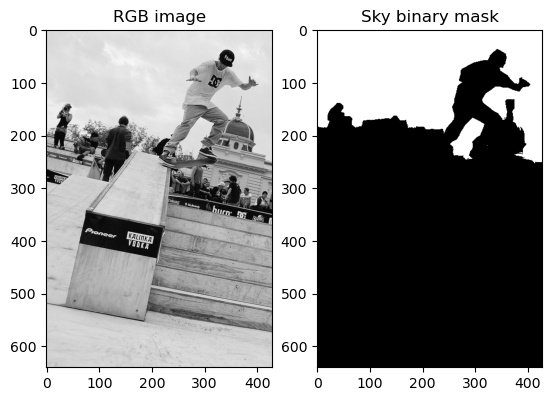

In [5]:
import random

rawDataset = SegmentationDataset('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky', None, None)

img, label = rawDataset[random.randint(0, len(rawDataset))]
display(img, label)



## Torch train / test split

In [6]:

train_ratio = 0.8
train_size = round(len(rawDataset) * train_ratio)
test_size = len(rawDataset) - train_size
train_set, val_set = torch.utils.data.random_split(rawDataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print( "train size: ", len(train_set), " test_size: ", len(val_set))

train size:  1342  test_size:  335


## WIP

In [7]:
img, label = rawDataset[5]
# display(img, label)

rgb = img.permute(1, 2, 0).numpy()


flatRgb = rgb.reshape(rgb.shape[0] * rgb.shape[1], 3)
flatLabel = label.numpy().flatten()
in_sky = flatRgb[flatLabel != 0]

print(in_sky.shape)



data = np.array([1,2,3,4,5,6,7,8,9,0])
mask = np.array([0,1,0,1,0,1,0,1,0,1])
print(data[mask.astype(bool)])


print(flatRgb.shape, flatLabel.shape)
flatRgb.shape

ini_array1 = np.array([[[1, 2, 3], [2, 4, 5], [1, 2, 3]],[[1, 2, 1], [2, 4, 1], [1, 2, 1]]])
ini_array1.shape
a = ini_array1.reshape(6,3)
a 
# plt.figure()
# plt.imshow(rgb)
# plt.title('hsv')
# plt.show()

(116057, 3)
[2 4 6 8 0]
(409600, 3) (409600,)


array([[1, 2, 3],
       [2, 4, 5],
       [1, 2, 3],
       [1, 2, 1],
       [2, 4, 1],
       [1, 2, 1]])

## Pytorch DataLoader

In [8]:
from torchvision import datasets, transforms

image_size = (64,64)

geometricTransforms = transforms.Compose([transforms.Resize(image_size),
                               ])

colorTransforms = transforms.Compose([transforms.ColorJitter(brightness=.1, hue=.05),                                      
                               ])


segmentationDataset = SegmentationDataset('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky', geometricTransforms, colorTransforms)
len(segmentationDataset)

1677

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(segmentationDataset, batch_size=5, shuffle=True)


Feature batch shape: torch.Size([5, 3, 64, 64])
Labels batch shape: torch.Size([5, 64, 64])


<Figure size 640x480 with 0 Axes>

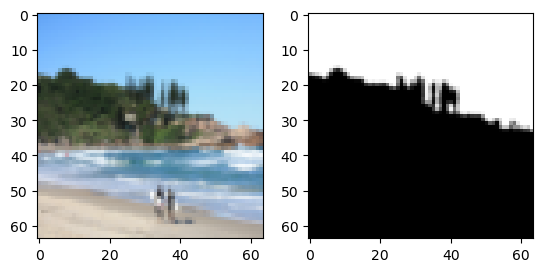

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0].squeeze()
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(label, cmap="gray")




# Fastai Unet

In [11]:

from fastai.vision.all import *

## Dataloader

In [12]:
import posixpath


def get_images(path):
    all_files = get_image_files(path)
    images = [i for i in all_files if str(i).endswith("jpg")]
    return images

def get_label(im_path):
    return ( posixpath.normpath(im_path) + '_skyMask.png')

In [13]:
path = Path('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky')
all_images = get_images(path)
all_images
get_label(all_images[0])

'/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/000000133567.jpg_skyMask.png'

In [14]:
codes = ['n' for element in range(256)]
codes[255] = 'y'
bs = 16


def get_msk(fn):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = get_label(fn)
    msk = np.array(PILMask.create(fn))
    return PILMask.create(msk)


def get_y(o): return get_msk(o)


In [15]:
blocks = (ImageBlock, MaskBlock())

In [16]:
segmentation_datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_images,
                   get_y=get_y,
                   item_tfms=Resize(64),
                   splitter=RandomSplitter(),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])


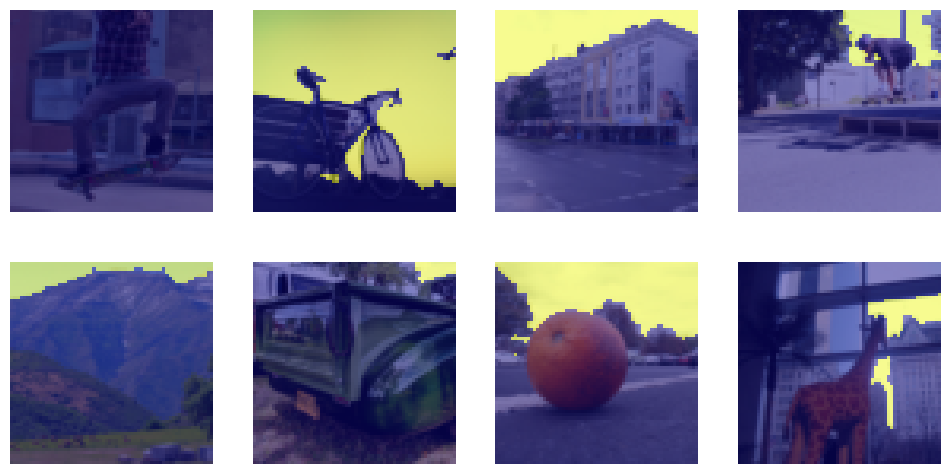

In [17]:
dls = segmentation_datablock.dataloaders(path, bs=8)
dls.show_batch(cmap='plasma', vmin=0, vmax=1)

# Unet training

In [18]:
# SqueezeNet resnet18 resnet34 mobilenet_v3_small
learn = unet_learner(dls, resnet34)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
#learn.lr_find()

In [24]:
learn.freeze()
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,time
0,0.145751,0.224814,00:27
1,0.137326,0.127409,00:26
2,0.102566,0.130930,00:26


In [27]:
learn.unfreeze()
learn.fit_one_cycle(6, 1e-5)

epoch,train_loss,valid_loss,time
0,0.099586,0.127362,00:31
1,0.096789,0.133493,00:32
2,0.089954,0.134954,00:28
3,0.086184,0.126838,00:28
4,0.084553,0.127950,00:28
5,0.081037,0.125622,00:27


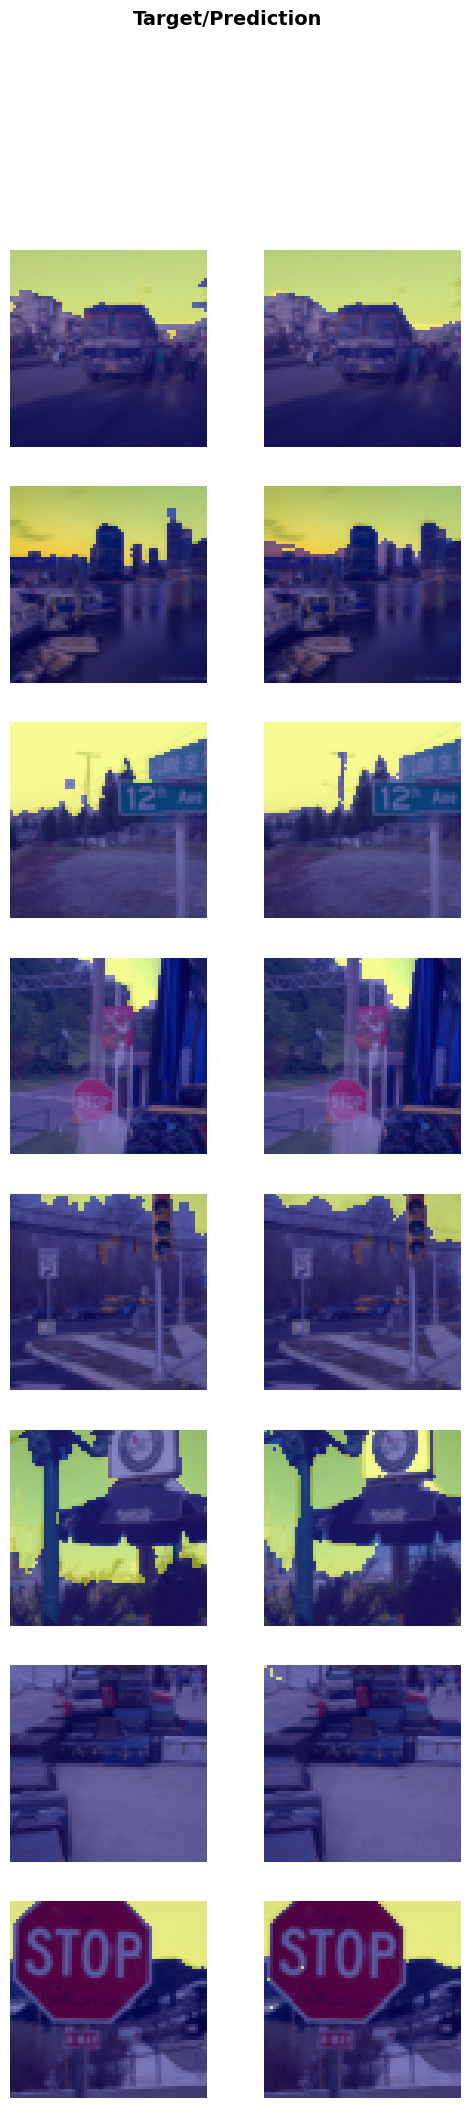

In [28]:
learn.show_results(cmap='plasma', vmin=0, vmax=3)

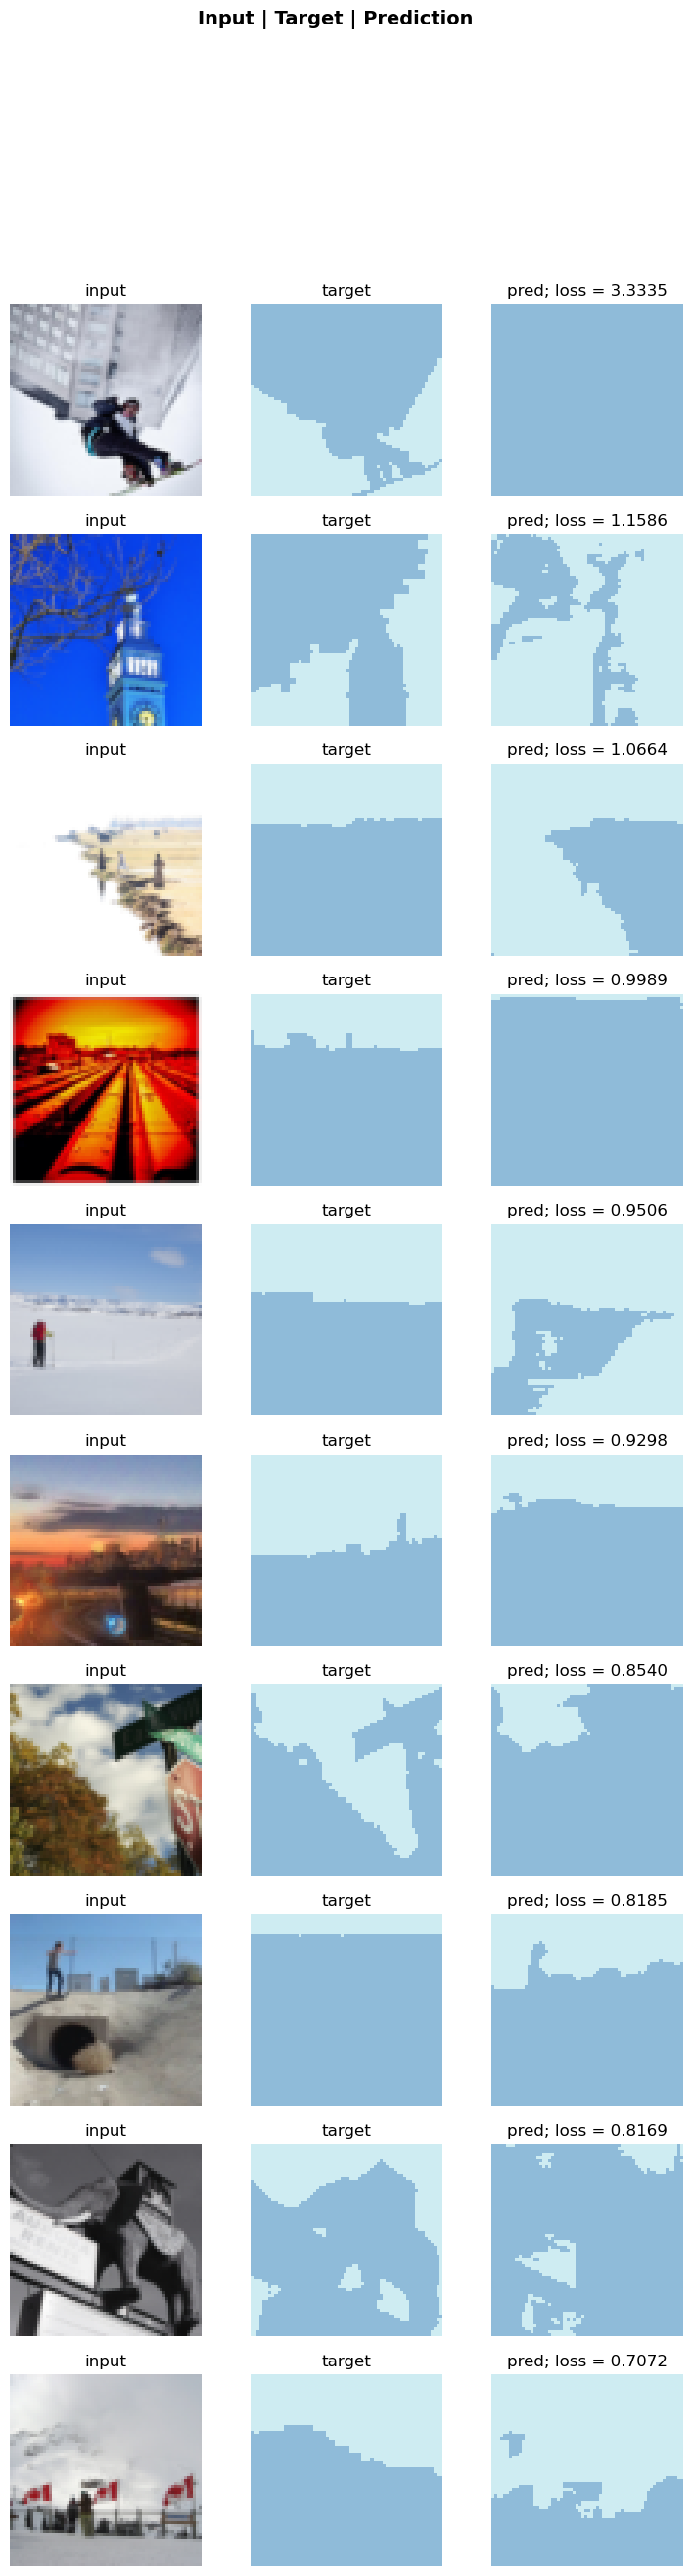

In [29]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=10)